In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input/testing-data-for-fer-model/test/sad 1.jpeg
../input/testing-data-for-fer-model/test/surprise 7.jpeg
../input/testing-data-for-fer-model/test/surprise 2.jpg
../input/testing-data-for-fer-model/test/angry 2.jpg
../input/testing-data-for-fer-model/test/photo-1542103749-8ef59b94f47e.jpeg
../input/testing-data-for-fer-model/test/angry3.jpg
../input/testing-data-for-fer-model/test/neutral 1.jpg
../input/testing-data-for-fer-model/test/surprise 1.jpg
../input/testing-data-for-fer-model/test/neutral 2.jpg
../input/testing-data-for-fer-model/test/surprise 4.jpg
../input/testing-data-for-fer-model/test/photo-1517677129300-07b130802f46.jpeg
../input/testing-data-for-fer-model/test/surprise 5.jpg
../input/testing-data-for-fer-model/test/surprise 3.jpg
../input/testing-data-for-fer-model/test/photo-1499887142886-791eca5918cd.jpeg
../input/testing-data-for-fer-model/test/sad 3.jpg
../input/testing-data-for-fer-model/test/surprise 6.jpeg
../input/testing-data-for-fer-model/test/photo-1551069

Import all the dependencies required for the Model

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from sklearn.metrics import accuracy_score
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


**Reading the CSV file which contains data of images**

In [3]:
data = pd.read_csv('../input/facial-emotion/fer2013.csv')
#check data shape
data.shape

(35887, 3)

In [4]:
#preview first 5 row of data
data.head(5)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [5]:
#check usage values
#80% training, 10% validation and 10% test
data.Usage.value_counts()

Training       28709
PrivateTest     3589
PublicTest      3589
Name: Usage, dtype: int64

**Counting the number of images available for each Classification**

In [6]:
#check target labels
emotion_map = {0: 'Angry', 1: 'Digust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
emotion_counts = data['emotion'].value_counts(sort=False).reset_index()
emotion_counts.columns = ['emotion', 'number']
emotion_counts['emotion'] = emotion_counts['emotion'].map(emotion_map)
emotion_counts

,emotion,number
0,Angry,4953
1,Digust,547
2,Fear,5121
3,Happy,8989
4,Sad,6077
5,Surprise,4002
6,Neutral,6198


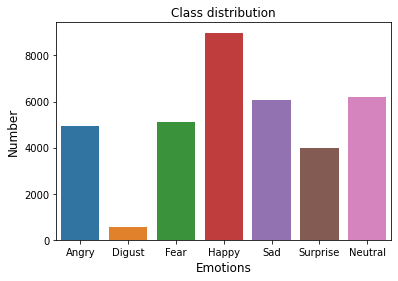

In [7]:
# Plotting a bar graph of the class distributions
plt.figure(figsize=(6,4))
sns.barplot(emotion_counts.emotion, emotion_counts.number)
plt.title('Class distribution')
plt.ylabel('Number', fontsize=12)
plt.xlabel('Emotions', fontsize=12)
plt.show()

**Let's Visualize some of the images of the train data**

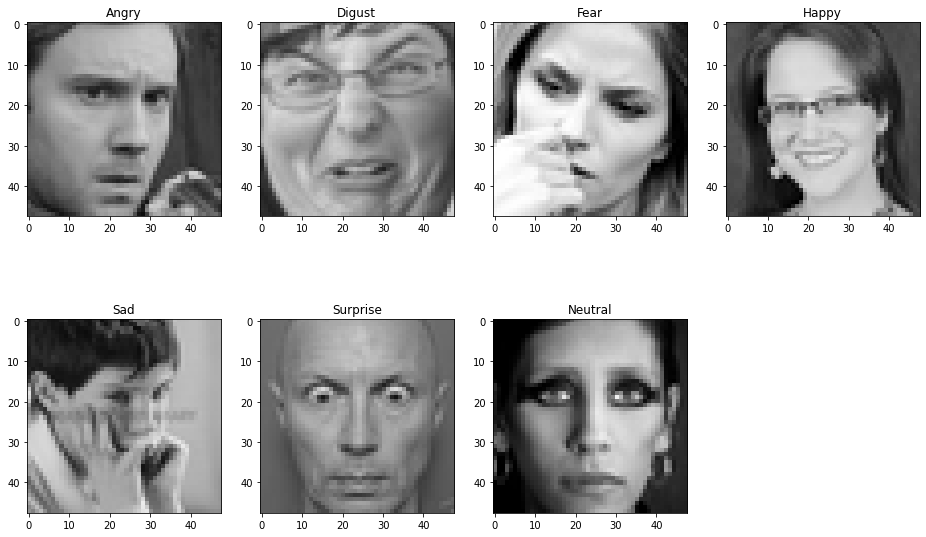

In [8]:
def row2image(row):
    pixels, emotion = row['pixels'], emotion_map[row['emotion']]
    img = np.array(pixels.split())
    img = img.reshape(48,48)
    image = np.zeros((48,48,3))
    image[:,:,0] = img
    image[:,:,1] = img
    image[:,:,2] = img
    return np.array([image.astype(np.uint8), emotion])

plt.figure(0, figsize=(16,10))
for i in range(1,8):
    face = data[data['emotion'] == i-1].iloc[0]
    img = row2image(face)
    plt.subplot(2,4,i)
    plt.imshow(img[0])
    plt.title(img[1])

plt.show()

**Seperating images for Train, Test and Valid**

In [9]:
#split data into training, validation and test set
data_train = data[data['Usage']=='Training'].copy()
data_val   = data[data['Usage']=='PublicTest'].copy()
data_test  = data[data['Usage']=='PrivateTest'].copy()
print("train shape: {}, \nvalidation shape: {}, \ntest shape: {}".format(data_train.shape, data_val.shape, data_test.shape))

train shape: (28709, 3), 
validation shape: (3589, 3), 
test shape: (3589, 3)


**Visualization of Classification of each category between Test, Train and Valid dataset**

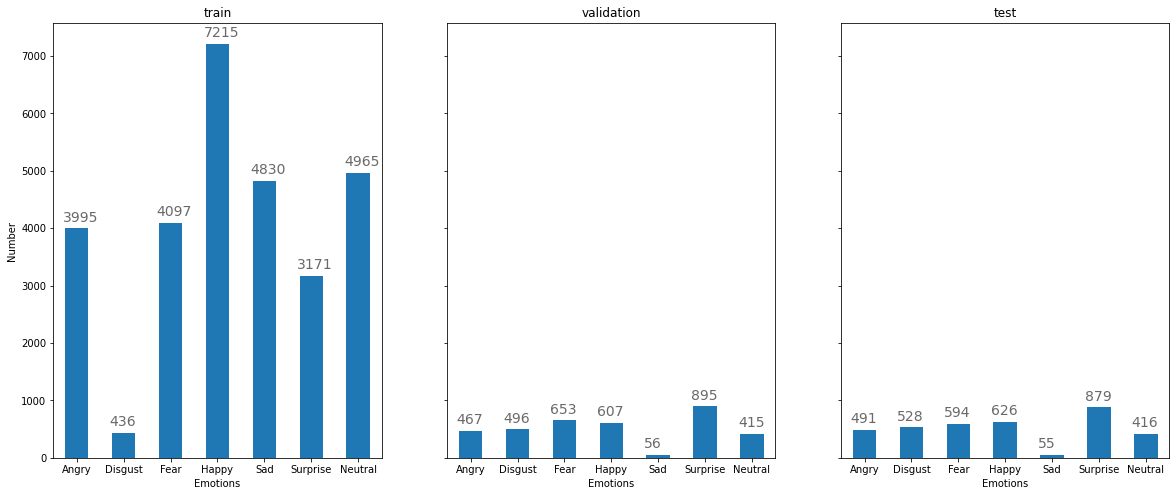

In [10]:
# barplot class distribution of train, val and test
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

def setup_axe(axe,df,title):
    df['emotion'].value_counts(sort=False).plot(ax=axe, kind='bar', rot=0)
    axe.set_xticklabels(emotion_labels)
    axe.set_xlabel("Emotions")
    axe.set_ylabel("Number")
    axe.set_title(title)
    
    # set individual bar lables using above list
    for i in axe.patches:
        # get_x pulls left or right; get_height pushes up or down
        axe.text(i.get_x()-.05, i.get_height()+120, \
                str(round((i.get_height()), 2)), fontsize=14, color='dimgrey',
                    rotation=0)

fig, axes = plt.subplots(1,3, figsize=(20,8), sharey=True)
setup_axe(axes[0],data_train,'train')
setup_axe(axes[1],data_val,'validation')
setup_axe(axes[2],data_test,'test')
plt.show()

# Building a Model

In [11]:
#initilize parameters
num_classes = 7 
width, height = 48, 48
num_epochs = 35
batch_size = 64
num_features = 64

****Data Preprocessing****

In [12]:
# CRNO stands for Convert, Reshape, Normalize, One-hot encoding
# (i) convert strings to lists of integers
# (ii) reshape and normalise grayscale image with 255.0
# (iii) one-hot encoding label, e.g. class 3 to [0,0,0,1,0,0,0]

def CRNO(df, dataName):
    df['pixels'] = df['pixels'].apply(lambda pixel_sequence: [int(pixel) for pixel in pixel_sequence.split()])
    data_X = np.array(df['pixels'].tolist(), dtype='float32').reshape(-1,width, height,1)/255.0   
    data_Y = to_categorical(df['emotion'], num_classes)  
    print(dataName, "_X shape: {}, ", dataName, "_Y shape: {}".format(data_X.shape, data_Y.shape))
    return data_X, data_Y

    
train_X, train_Y = CRNO(data_train, "train") #training data
val_X, val_Y     = CRNO(data_val, "val") #validation data
test_X, test_Y   = CRNO(data_test, "test") #test data

train _X shape: {},  train _Y shape: (28709, 48, 48, 1)
val _X shape: {},  val _Y shape: (3589, 48, 48, 1)
test _X shape: {},  test _Y shape: (3589, 48, 48, 1)


In [13]:
model = Sequential()

#module 1
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), input_shape=(width, height, 1), data_format='channels_last'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 2
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(2*num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#module 3
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(num_features, kernel_size=(3, 3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

#flatten
model.add(Flatten())

#dense 1
model.add(Dense(2*2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 2
model.add(Dense(2*2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#dense 3
model.add(Dense(2*num_features))
model.add(BatchNormalization())
model.add(Activation('relu'))

#output layer
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7), 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 256)       2560      
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 256)       590080    
_________________________________________________________________
batch_normalization_2 (Batch (None, 46, 46, 256)       1024      
_________________________________________________________________
activation_2 (Activation)    (None, 46, 46, 256)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 23, 23, 256)      

In [14]:
# data generator
data_generator = ImageDataGenerator(
                        featurewise_center=False,
                        featurewise_std_normalization=False,
                        rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        zoom_range=.1,
                        horizontal_flip=True)

**Creating Callbacks**

In [15]:
from keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
from keras.callbacks import ReduceLROnPlateau

patience = 10
early_stop = EarlyStopping('val_loss', patience=patience, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.1, patience=5, verbose=1)

model_names = 'Facial_Recognition_Model.hdf5'
model_checkpoint = ModelCheckpoint(model_names, 'val_loss', verbose=1,save_best_only=True)
callbacks = [model_checkpoint,early_stop, reduce_lr]

In [16]:
hist = model.fit_generator(data_generator.flow(train_X, train_Y, batch_size),
                                steps_per_epoch=len(train_X) / batch_size,
                                epochs=num_epochs,
                                verbose=1, 
                                callbacks = callbacks,
                                validation_data=(val_X, val_Y))

Epoch 1/35
449/448 [==============================] - 51s 113ms/step - loss: 1.7052 - accuracy: 0.3193 - val_loss: 2.2022 - val_accuracy: 0.3135

Epoch 00001: val_loss improved from inf to 2.20223, saving model to Facial_Recognition_Model.hdf5
Epoch 2/35
449/448 [==============================] - 44s 97ms/step - loss: 1.3930 - accuracy: 0.4622 - val_loss: 1.3041 - val_accuracy: 0.5049

Epoch 00002: val_loss improved from 2.20223 to 1.30409, saving model to Facial_Recognition_Model.hdf5
Epoch 3/35
449/448 [==============================] - 44s 97ms/step - loss: 1.2455 - accuracy: 0.5224 - val_loss: 1.4778 - val_accuracy: 0.4313

Epoch 00003: val_loss did not improve from 1.30409
Epoch 4/35
449/448 [==============================] - 44s 98ms/step - loss: 1.1696 - accuracy: 0.5558 - val_loss: 1.1236 - val_accuracy: 0.5723

Epoch 00004: val_loss improved from 1.30409 to 1.12358, saving model to Facial_Recognition_Model.hdf5
Epoch 5/35
449/448 [==============================] - 44s 97ms/ste

# Visualizing the Performance of the model

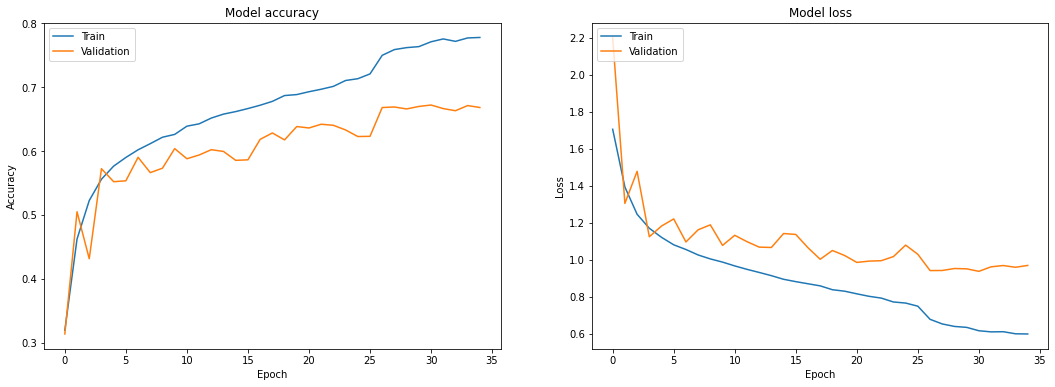

In [17]:
fig, axes = plt.subplots(1,2, figsize=(18, 6))
# Plot training & validation accuracy values
axes[0].plot(hist.history['accuracy'])
axes[0].plot(hist.history['val_accuracy'])
axes[0].set_title('Model accuracy')
axes[0].set_ylabel('Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
axes[1].plot(hist.history['loss'])
axes[1].plot(hist.history['val_loss'])
axes[1].set_title('Model loss')
axes[1].set_ylabel('Loss')
axes[1].set_xlabel('Epoch')
axes[1].legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Predicting the Emotions of the Test Data

In [18]:
test_true = np.argmax(test_Y, axis=1)
test_pred = np.argmax(model.predict(test_X), axis=1)
print("CNN Model Accuracy on test set: {:.4f}".format(accuracy_score(test_true, test_pred)))

CNN Model Accuracy on test set: 0.6812


# Let us Predict the Emotions of the other dataset

In [19]:
from keras.models import load_model
import cv2
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from time import sleep
from skimage import io

Expression Prediction: Sad


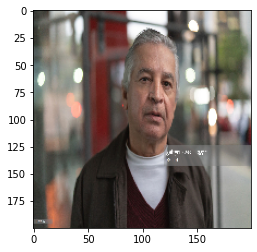

In [22]:
classifier = load_model('/kaggle/working/Facial_Recognition_Model.hdf5')
class_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

test_images = ['../input/testing-data-for-fer-model/test/neutral 1.jpg']


img = image.load_img(test_images[0], color_mode = "grayscale", target_size=(48, 48))
show_img=image.load_img(test_images[0], grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255.

pred = classifier.predict(x)[0]
label = class_labels[pred.argmax()]

plt.imshow(show_img)
print('Expression Prediction:',label)

Expression Prediction: Surprise


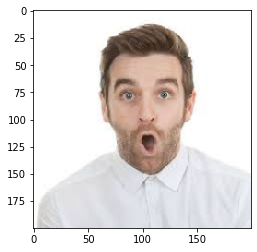

In [24]:
test_images = ['../input/testing-data-for-fer-model/test/surprise 6.jpeg']
img = image.load_img(test_images[0], color_mode = "grayscale", target_size=(48, 48))
show_img=image.load_img(test_images[0], grayscale=False, target_size=(200, 200))
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)

x /= 255.

pred = classifier.predict(x)[0]
label = class_labels[pred.argmax()]

plt.imshow(show_img)
print('Expression Prediction:',label)

# Predicting the Face Emotions of the Image with Bounding Box

In [ ]:
test_images = ['../input/testing-data-for-fer-model/test/surprise 6.jpeg']

img = image.load_img(test_images[0], color_mode = "grayscale", target_size=(48, 48))

x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x /= 255.

pred = classifier.predict(x)[0]
label = class_labels[pred.argmax()]

face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades +'haarcascade_frontalface_default.xml')
img = cv2.imread('../input/testing-data-for-fer-model/test/surprise 6.jpeg')
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray,1.3,5)
EMOTIONS = ["angry","disgust","scared", "happy", "sad", "surprised","neutral"]

for x,y,w,h in faces:
    img = cv2.rectangle(img, (x,y),(x+w,y+h),(255,0,0),2)
    img = cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)

cv2.imshow('image',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Predicting the Face Emotions of Video with Bounding Box

In [ ]:
# parameters for loading data and images
detection_model_path = 'haarcascade_frontalface_default.xml'
emotion_model_path = 'Facial_Recognition_Model.hdf5'

# hyper-parameters for bounding boxes shape
# loading models
face_detection = cv2.CascadeClassifier(cv2.data.haarcascades + detection_model_path)
emotion_classifier = load_model(emotion_model_path, compile=False)
EMOTIONS = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']


# starting video streaming
cv2.namedWindow('your_face')
camera = cv2.VideoCapture(0)
while True:
    frame = camera.read()[1]
    #reading the frame
    frame = imutils.resize(frame,width=300)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    faces = face_detection.detectMultiScale(gray,scaleFactor=1.1,minNeighbors=5,minSize=(30,30),flags=cv2.CASCADE_SCALE_IMAGE)
    
    canvas = np.zeros((250, 300, 3), dtype="uint8")
    frameClone = frame.copy()
    
    if len(faces) > 0:
        faces = sorted(faces, reverse=True,key=lambda x: (x[2] - x[0]) * (x[3] - x[1]))[0]
        (fX, fY, fW, fH) = faces
                    # Extract the ROI of the face from the grayscale image, resize it to a fixed 28x28 pixels, and then prepare
            # the ROI for classification via the CNN
        roi = gray[fY:fY + fH, fX:fX + fW]
        roi = cv2.resize(roi, (48, 48))
        roi = roi.astype("float") / 255.0
        roi = img_to_array(roi)
        roi = np.expand_dims(roi, axis=0)
        
        
        preds = emotion_classifier.predict(roi)[0]
        emotion_probability = np.max(preds)
        label = EMOTIONS[preds.argmax()]
    else: continue

 
    for (i, (emotion, prob)) in enumerate(zip(EMOTIONS, preds)):
                # construct the label text
                text = "{}: {:.2f}%".format(emotion, prob * 100)

                # draw the label + probability bar on the canvas                
                w = int(prob * 300)
                cv2.rectangle(canvas, (7, (i * 35) + 5),
                (w, (i * 35) + 35), (0, 0, 255), -1)
                cv2.putText(canvas, text, (10, (i * 35) + 23),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45,
                (255, 255, 255), 2)
                cv2.putText(frameClone, label, (fX, fY - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 2)
                cv2.rectangle(frameClone, (fX, fY), (fX + fW, fY + fH),
                              (0, 0, 255), 2)

    cv2.imshow('your_face', frameClone)
    cv2.imshow("Probabilities", canvas)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

camera.release()
cv2.destroyAllWindows()